In [1]:
import voxelmorph2d as vm2d
import voxelmorph3d as vm3d

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import glob
import os
from dataset import DataSet
import warnings

import cv2
import math
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """

    def __init__(self, input_dims, is_2d=False, use_gpu=False):
        self.dims = input_dims
        if is_2d:
            self.vm = vm2d
            self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        else:
            self.vm = vm3d
            self.voxelmorph = vm3d.VoxelMorph3d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.SGD(self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=9, lamda=0.01, is_training=True):
        loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss

    def train_model(self, batch_moving, batch_fixed, n=9, lamda=0.01, return_metric_score=True):
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(self.device), batch_moving.to(self.device)
        registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
        print(batch_fixed.shape)
        train_loss = self.calculate_loss(registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return train_loss, train_dice_score
        return train_loss

    def get_test_loss(self, batch_moving, batch_fixed, n=9, lamda=0.01):
        with torch.set_grad_enabled(False):
            registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score

In [3]:
def savebin(arr,name):
    gray_arr = (arr - arr.min()) * 255 / (arr.max() - arr.min())
    gray_arr = gray_arr.astype('uint8')
    gray_img = Image.fromarray(gray_arr, mode='L')
#     plt.imshow(gray_arr,cmap='gray')
#     plt.show()
    gray_img.save(name)

def saveRGB(arr,name):
    cv2.imwrite(name, arr, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [4]:
def read_pic(fixed_path,moving_path):
    train_files_moving = glob.glob(os.path.join(moving_path, '*.dcm'))
    train_files_fixed = glob.glob(os.path.join(fixed_path, "*.dcm"))
    train_files_moving.sort()
    train_files_fixed.sort()

    DS1 = DataSet(train_files_moving)
    DS2 = DataSet(train_files_fixed)
    print("Number of training moving images: ", len(DS1))
    print("Number of training fixed images: ", len(DS2))
    moving_list = []
    fixed_list = []

    l = len(DS1)
    for i in range(l):
        moving_list.append(DS1[i])
        fixed_list.append(DS2[i])

    for i in range(l):
        c = moving_list[i].cpu().detach().numpy()
        m = c.max()
        l = c.min()
        moving_list[i] = (moving_list[i] - torch.tensor(l)) / (m - l) * 255

    for i in range(l):
        c = fixed_list[i].cpu().detach().numpy()
        m = c.max()
        l = c.min()
        fixed_list[i] = (fixed_list[i] - torch.tensor(l)) / (m - l) * 255

    moving_list1 = torch.tensor([item.cpu().detach().numpy() for item in moving_list])
    fixed_list1 = torch.tensor([item.cpu().detach().numpy() for item in fixed_list])

    custom_dataset = data.TensorDataset(moving_list1, fixed_list1)

    custom_generator = data.DataLoader(custom_dataset, batch_size=32, shuffle=True)

    return custom_dataset,custom_generator,l

In [31]:
fixp="./fix"
movingp="./moving"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
validation_set,validation_generator,length=read_pic(fixp,movingp)

Number of training moving images:  9
Number of training fixed images:  9


In [22]:
vm = VoxelMorph((1, 256, 256), is_2d=True,  use_gpu=True)  # Obje
# ct of the higher level class
generator = vm.voxelmorph
model = generator.to(device)
state_dict = torch.load('_G_best_CrossEn_5_3.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [32]:
val_moving_test = validation_set[0:9][0].permute(0, 3, 2, 1)
val_fixed_test = validation_set[0:9][1].permute(0, 3, 2, 1)

val_moving_test = val_moving_test.cuda().float()
val_fixed_test = val_fixed_test.cuda().float()

In [33]:
val_registered_test, defor_test = model(val_moving_test, val_fixed_test)

In [9]:
def savefixed(arr,name):#保存函数，输入为一个灰度二维arr，以及将要保存的名字（需要提前使用pydicom将fixed_image读取为ndarry格式再输入）
# 缩放到0-255范围内
    gray_arr = (arr - arr.min()) * 255 / (arr.max() - arr.min())
    # 转换为整数类型
    gray_arr = gray_arr.astype('uint8')
    gray_img = Image.fromarray(gray_arr, mode='L')
    # plt.imshow(gray_arr,cmap='gray')
    # plt.show()
    gray_img.save(name)

In [10]:
def save_regisrated(arr,name):#保存函数，输入一个配准后的二维arr，以及要保存的名字。
    moving_arr = (arr - arr.min()) * 255 / (arr.max() - arr.min())#很关键，不然转化为三维后就是依托
    moving_red_image = np.zeros((moving_arr.shape[0], moving_arr.shape[1], 3), dtype=np.uint8)
    moving_red_image[:,:,0] = 0
    moving_red_image[:,:,1] = 0
    moving_red_image[:,:,2] = moving_arr
    cv2.imwrite(name, moving_red_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    
def registrated_on_fixed(fixedname,registrated_name,redrate,grayrate,name):

    # 读取RGB图像和灰度图像
    rgb_image = cv2.imread(registrated_name,cv2.IMREAD_COLOR)
    gray_image = cv2.imread(fixedname, cv2.IMREAD_GRAYSCALE)
    # 调整图像大小
    height, width, _ = rgb_image.shape
    gray_image = cv2.resize(gray_image, (width, height))

    # 将灰度图像转换为3通道图像
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

    # 将RGB图像和灰度图像相加
    result = cv2.addWeighted(rgb_image, redrate, gray_image, grayrate, 0)
    # 保存图像
    cv2.imwrite(name, result)

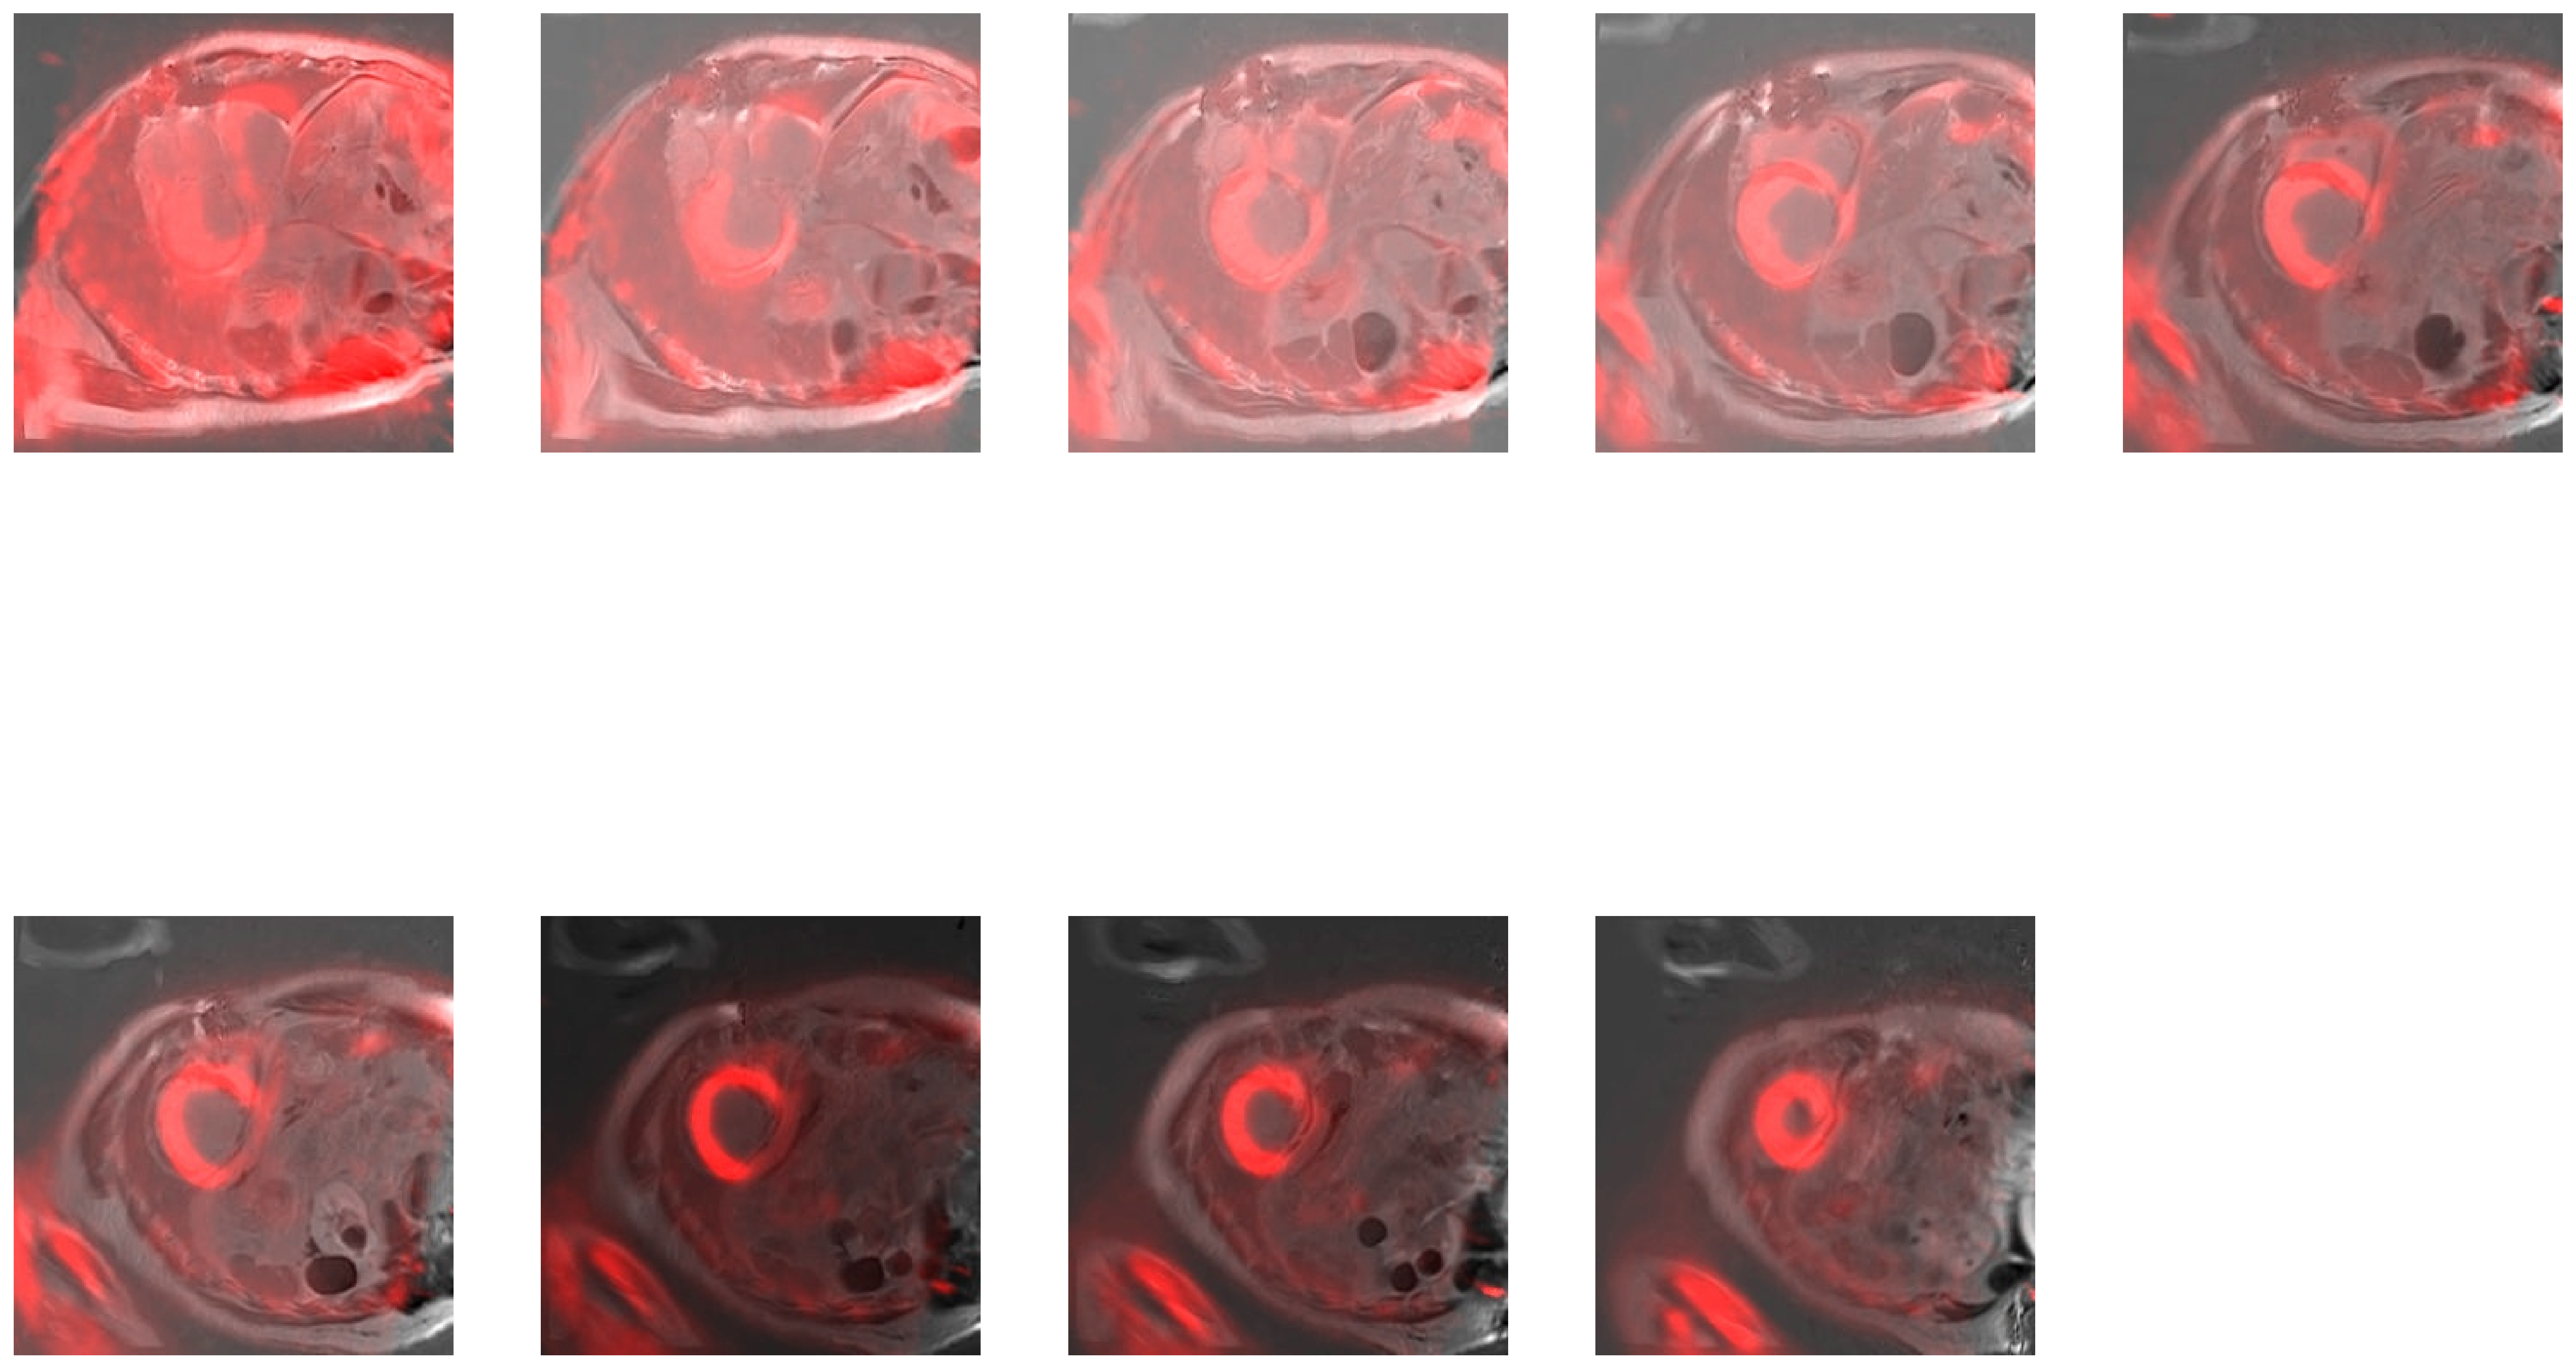

In [34]:
plt.figure(dpi=300,figsize=(24,16))
for i in range(1,10):
    reg=val_registered_test[i-1].cpu().data.numpy().squeeze()
    fix=val_fixed_test[i-1].cpu().data.numpy().squeeze()

#     kernel = np.ones((5, 5), dtype=np.uint8)
#     reg = cv2.erode(reg, kernel, iterations=1)
    fix_path="./fix_test_5/"+str(i)+"_fixed_image_train.jpg"
    reg_path="./reg_test_5/"+str(i)+"_reg_image_train.jpg"
    
    savefixed(fix,fix_path)
    save_regisrated(reg,reg_path)
    
    registrated_on_fixed(fix_path,reg_path,2,1,"resampled.jpg")
#     cv2.imwrite("./fusion"+str(i)+".jpg", result)
#     # 显示新图像
    resampled_image = cv2.imread('resampled.jpg')
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(resampled_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")


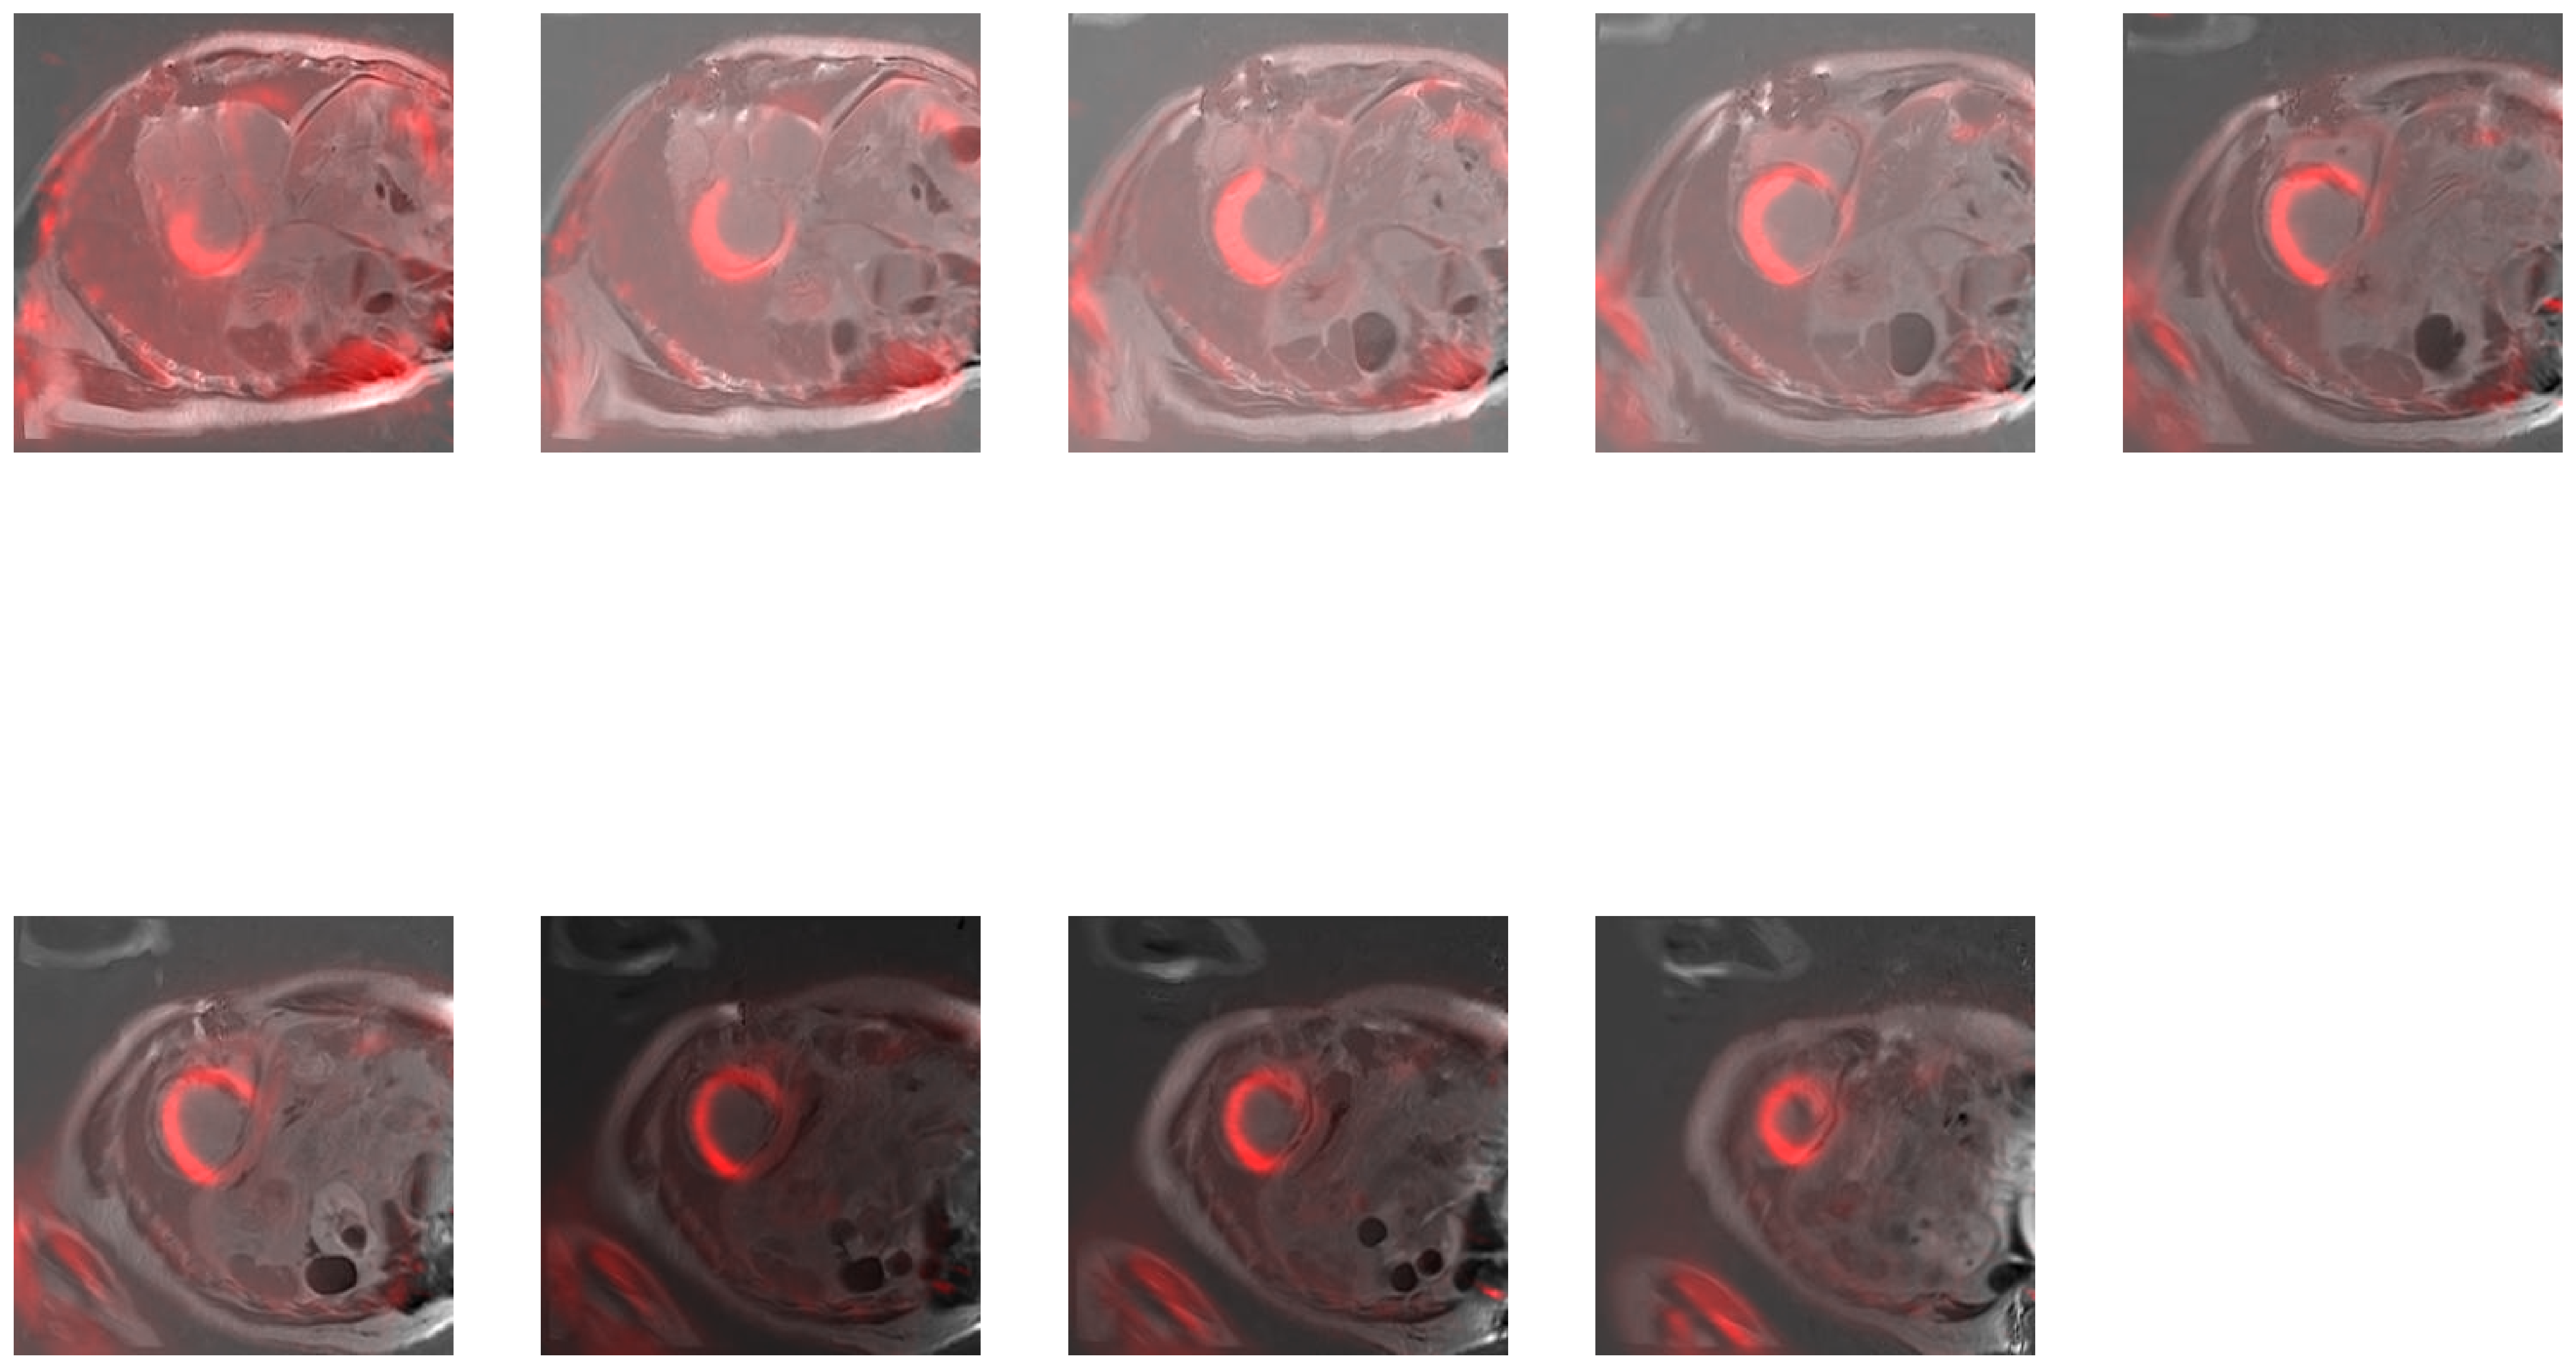

In [35]:
plt.figure(dpi=300,figsize=(24,16))
for i in range(1,10):
    moving=val_moving_test[i-1].cpu().data.numpy().squeeze()
    fix=val_fixed_test[i-1].cpu().data.numpy().squeeze()
    
    
#     kernel = np.ones((5, 5), dtype=np.uint8)
#     reg = cv2.erode(reg, kernel, iterations=1)
    fix_path="./fix_test_5/"+str(i)+"_fixed_image_train.jpg"
    moving_path="./moving_test_5/"+str(i)+"_moving_image_train.jpg"
    
    savefixed(fix,fix_path)
    save_regisrated(moving,moving_path)
    
    # 读取第一幅图像
    img1 = cv2.imread(fix_path,cv2.IMREAD_GRAYSCALE)

    # 读取第二幅图像
    img2 = cv2.imread(moving_path,cv2.IMREAD_COLOR)

    height, width, _ = img2.shape
    img1 = cv2.resize(img1, (width, height))
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    
    # 将两幅图像以不同颜色叠加到一张新图上
    img = cv2.addWeighted(img1, 1, img2, 1, 0)

    # 将第一幅图像的像素值设为蓝色
    img[:, :, 1] = img1[:,:,2]

    # # 将第二幅图像的像素值设为绿色
    # img[:, :, 1] = img2[:, :, 1]

    # 显示新图像
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")